# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import spacy

from tqdm.auto import tqdm

from lightgbm import LGBMClassifier

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import nltk
from nltk.corpus import stopwords

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
display(df_reviews[df_reviews['votes'].isnull()])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
display(df_reviews[df_reviews['end_year'] != '\\N'])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
325,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,No rubbish - no where even near rubbish. Not a...,8,pos,1,train,2496
326,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,"A weird, witty and wonderful depiction of fami...",9,pos,1,train,2495
327,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,"Typical 90's comedy, situational comedy simila...",10,pos,1,train,2493
328,tt0101032,tvSeries,2point4 Children,2point4 Children,1991,1999,40,0,Comedy,6.9,1030,This first two seasons of this comedy series w...,10,pos,1,train,2494
340,tt0437696,tvSeries,30 Days,30 Days,2005,2008,60,0,"Documentary,Reality-TV",7.9,1876,This video has audio that is meant for someone...,1,neg,0,test,4013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47306,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143,"Out of boredom and vast curiosity, I decided t...",2,neg,0,test,5665
47307,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143,"Miranda Cosgrove is known for her debut in ""Sc...",3,neg,0,test,5653
47308,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143,"I won't say the show is all bad, because there...",3,neg,0,test,5671
47309,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143,First off... I have to say acting isn't very g...,4,neg,0,test,5656


In [9]:
display(df_reviews[df_reviews['runtime_minutes'] == '\\N'])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
338,tt0775558,tvSeries,3 lbs.,3 lbs.,2006,\N,\N,0,Drama,6.8,410,3lbs is obviously just a self indulgent progra...,1,neg,0,train,5833
339,tt0775558,tvSeries,3 lbs.,3 lbs.,2006,\N,\N,0,Drama,6.8,410,I watched the pilot and noticed more than a fe...,4,neg,0,train,5834
1272,tt0462600,movie,A Texas Tale of Treason,A Texas Tale of Treason,2006,\N,\N,0,Sci-Fi,7.5,40,watch this movie. it's truly a good ride throu...,7,pos,1,test,9238
1273,tt0462600,movie,A Texas Tale of Treason,A Texas Tale of Treason,2006,\N,\N,0,Sci-Fi,7.5,40,Everyone who has ever wondered how to make a f...,7,pos,1,test,9241
1274,tt0462600,movie,A Texas Tale of Treason,A Texas Tale of Treason,2006,\N,\N,0,Sci-Fi,7.5,40,This film would be particularly fun for anyone...,8,pos,1,test,9237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46799,tt0294230,tvSeries,Yeh Jo Hai Zindagi,Yeh Jo Hai Zindagi,1984,\N,\N,0,Comedy,8.6,276,"I am a firm believer that a film, TV serial or...",7,pos,1,test,1872
46800,tt0294230,tvSeries,Yeh Jo Hai Zindagi,Yeh Jo Hai Zindagi,1984,\N,\N,0,Comedy,8.6,276,I saw this title again on Shemaroo. I also ask...,8,pos,1,test,1870
46801,tt0294230,tvSeries,Yeh Jo Hai Zindagi,Yeh Jo Hai Zindagi,1984,\N,\N,0,Comedy,8.6,276,This sitcom was a big crowd puller in the year...,10,pos,1,test,1868
46802,tt0294230,tvSeries,Yeh Jo Hai Zindagi,Yeh Jo Hai Zindagi,1984,\N,\N,0,Comedy,8.6,276,i was a huge fan of this series. Yesterday i w...,10,pos,1,test,1869


In [10]:
display(df_reviews[df_reviews['genres'] == '\\N'])

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
8200,tt0497896,tvEpisode,Cream Reunion Concert,Cream Reunion Concert,2005,\N,130,0,\N,8.6,81,I caught a bit of this concert on public telev...,10,pos,1,train,1299
8201,tt0497896,tvEpisode,Cream Reunion Concert,Cream Reunion Concert,2005,\N,130,0,\N,8.6,81,I first saw a track from this DVD at a hifi sh...,10,pos,1,train,1300
8202,tt0497896,tvEpisode,Cream Reunion Concert,Cream Reunion Concert,2005,\N,130,0,\N,8.6,81,"I've loved all of Cream's work, even as there ...",10,pos,1,train,1301
8203,tt0497896,tvEpisode,Cream Reunion Concert,Cream Reunion Concert,2005,\N,130,0,\N,8.6,81,So often a band will get together for a re-uni...,10,pos,1,train,1302
8204,tt0497896,tvEpisode,Cream Reunion Concert,Cream Reunion Concert,2005,\N,130,0,\N,8.6,81,"Eric Clapton, Jack Bruce and Ginger Baker re-u...",10,pos,1,train,1303
11519,tt0311066,video,Electric Light Orchestra: Zoom Tour Live,Electric Light Orchestra: Zoom Tour Live,2001,\N,98,0,\N,8.8,118,"I'm sorry, ELO fans, but I was disappointed wi...",3,neg,0,test,5587
19845,tt0316142,tvEpisode,Kurosawa,Kurosawa,2000,\N,115,0,\N,7.2,360,There is a phrase by the experimental filmmake...,1,neg,0,test,3768
20779,tt0116907,tvEpisode,Long Day's Journey Into Night,Long Day's Journey Into Night,1995,\N,173,0,\N,8.8,119,This movie was very good. I really enjoyed it....,10,pos,1,test,705
21966,tt0292102,videoGame,Men in Black: The Series 2,Men in Black: The Series 2,2000,\N,\N,0,\N,5.5,65,"The trailers get you to the movie, but the mov...",3,neg,0,train,4561
21967,tt0292102,videoGame,Men in Black: The Series 2,Men in Black: The Series 2,2000,\N,\N,0,\N,5.5,65,Men In Black 2 was a real disappointment for m...,4,neg,0,train,4560


In [11]:
# Replace '\N' with NaN
df_reviews['runtime_minutes'].replace('\\N', np.nan, inplace=True)

# Drop rows where runtime_minutes, average_rating or votes are NaN
df_reviews.dropna(subset=['end_year', 'runtime_minutes', 'average_rating', 'votes'], inplace=True)

# Convert runtime_minutes to float
df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].astype(float)

In [12]:
# Fill genres with 'Unknown'
df_reviews['genres'].fillna('Unknown', inplace=True)

In [13]:
df_reviews.duplicated().sum()

0

In [14]:
df_reviews['review'].duplicated().sum()

91

In [15]:
# Keep the first occurrence of each duplicated review
df_reviews.drop_duplicates(subset=['review'], keep='first', inplace=True)

# Check the number of duplicated reviews
print(df_reviews['review'].duplicated().sum())

0


In [16]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46752 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           46752 non-null  object 
 1   title_type       46752 non-null  object 
 2   primary_title    46752 non-null  object 
 3   original_title   46752 non-null  object 
 4   start_year       46752 non-null  int64  
 5   end_year         46752 non-null  object 
 6   runtime_minutes  46752 non-null  float64
 7   is_adult         46752 non-null  int64  
 8   genres           46752 non-null  object 
 9   average_rating   46752 non-null  float64
 10  votes            46752 non-null  Int64  
 11  review           46752 non-null  object 
 12  rating           46752 non-null  int64  
 13  sp               46752 non-null  object 
 14  pos              46752 non-null  int64  
 15  ds_part          46752 non-null  object 
 16  idx              46752 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

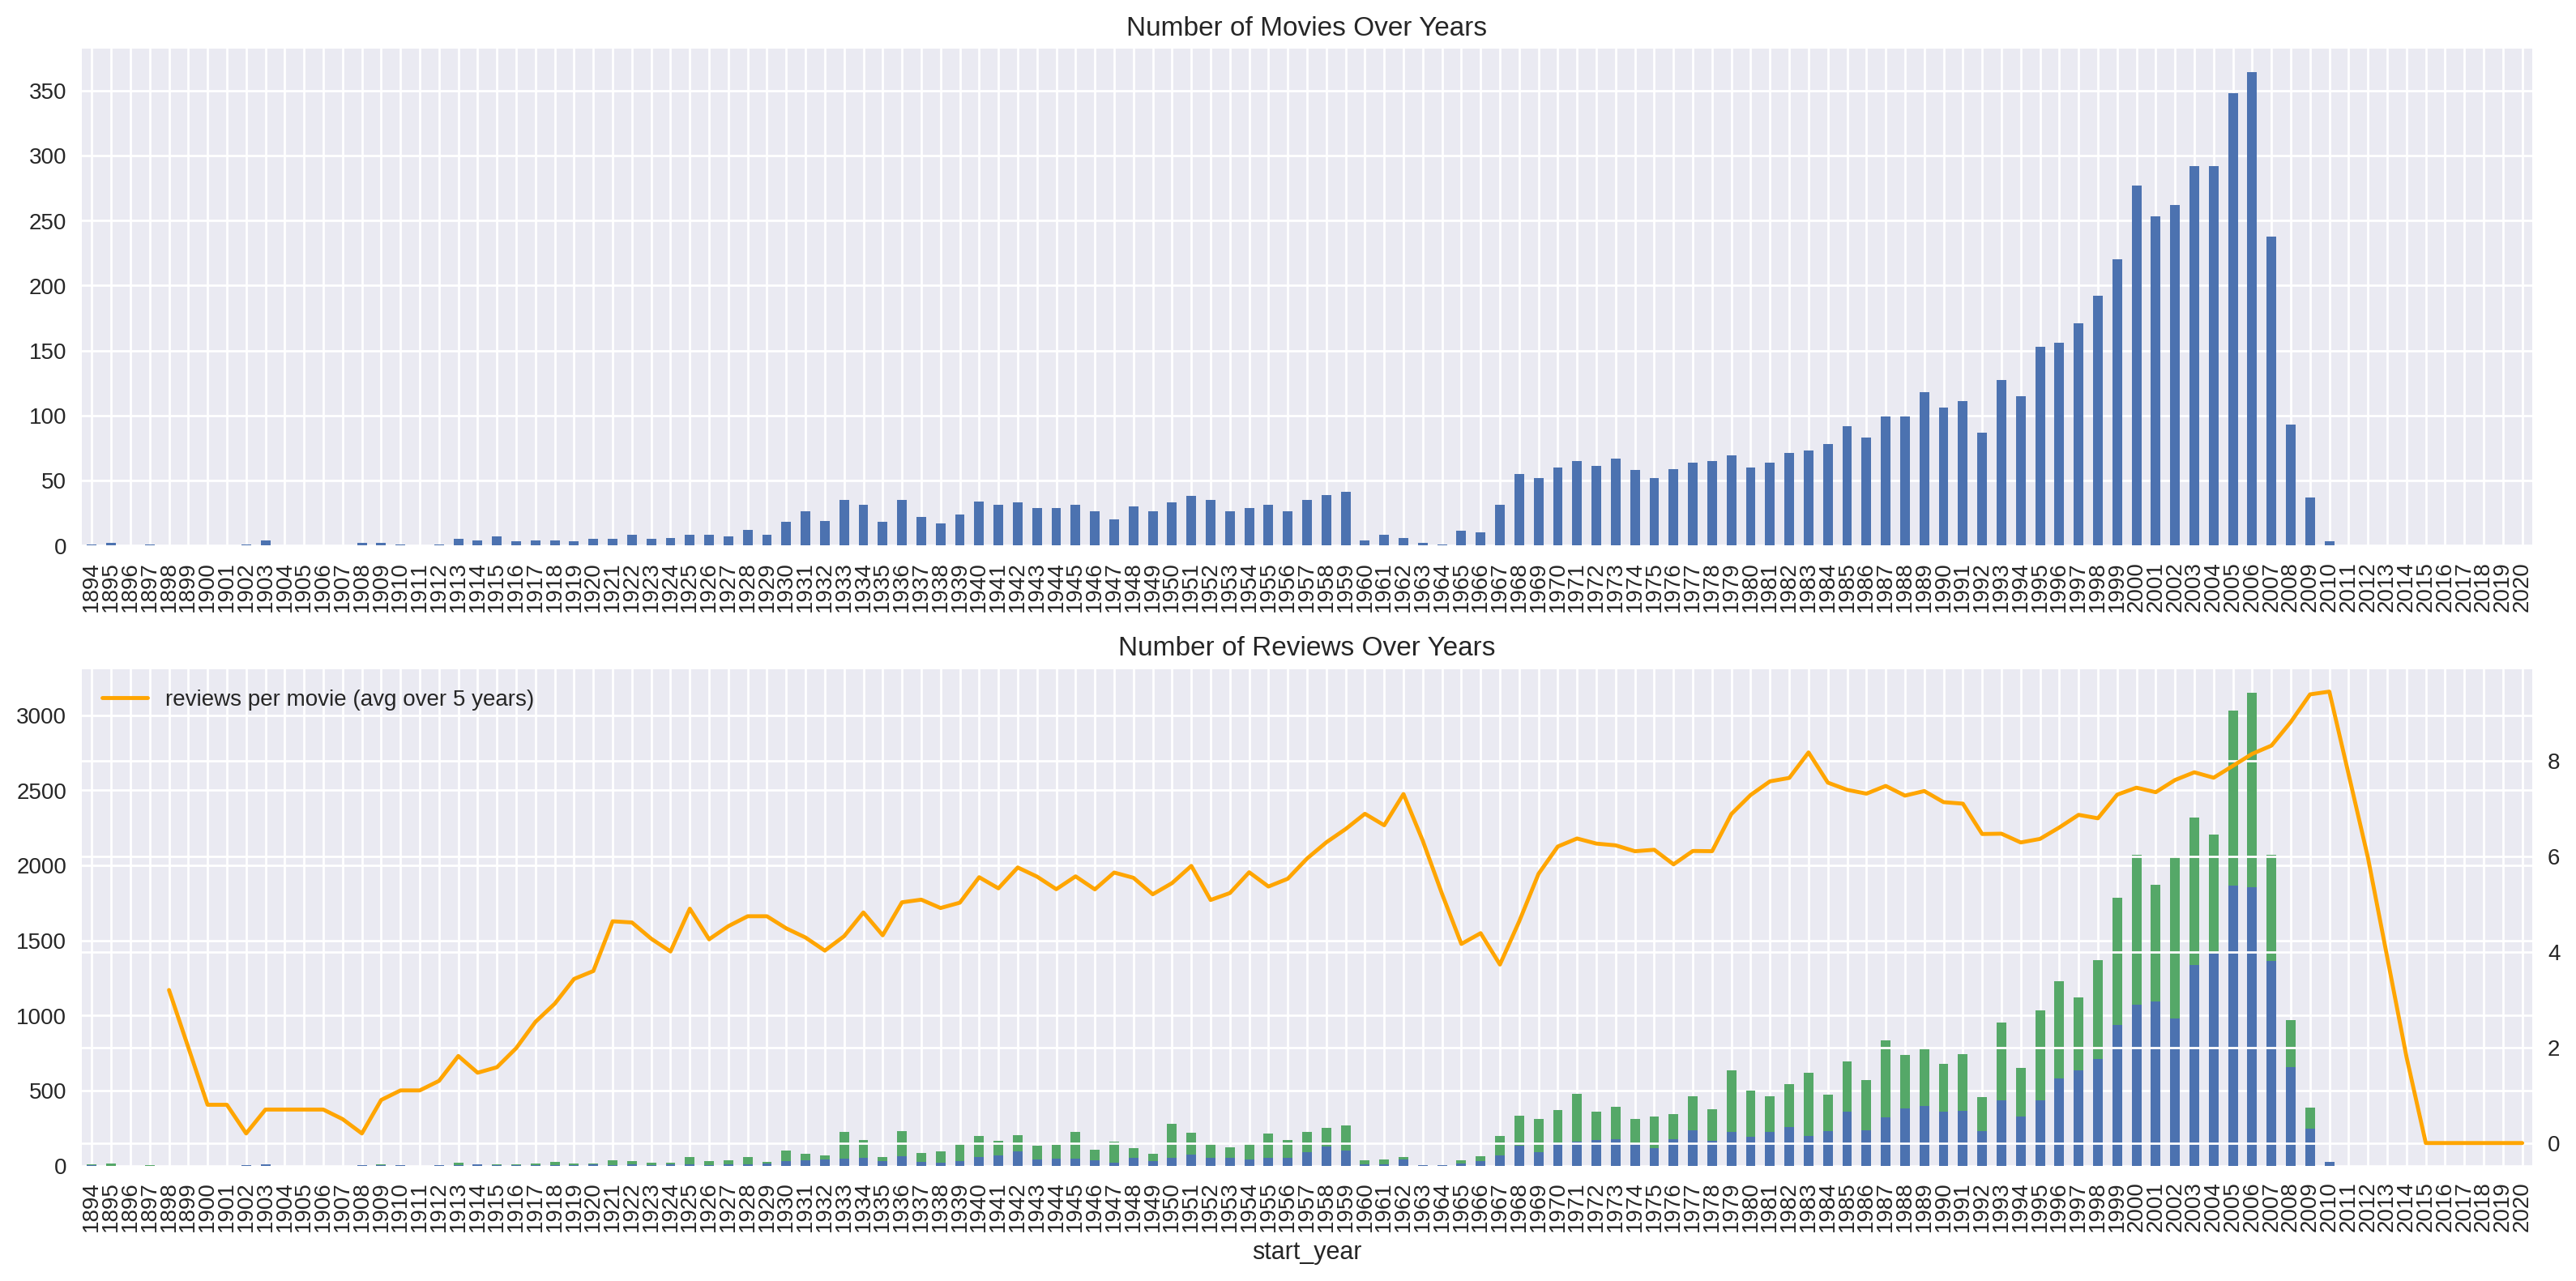

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

In these graphs we can see a steady increase in the number of movies over the years until near the year that the dataset was created in 2011. The avgerage number of reviews increases over the years but not proportionately to the number of movies.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

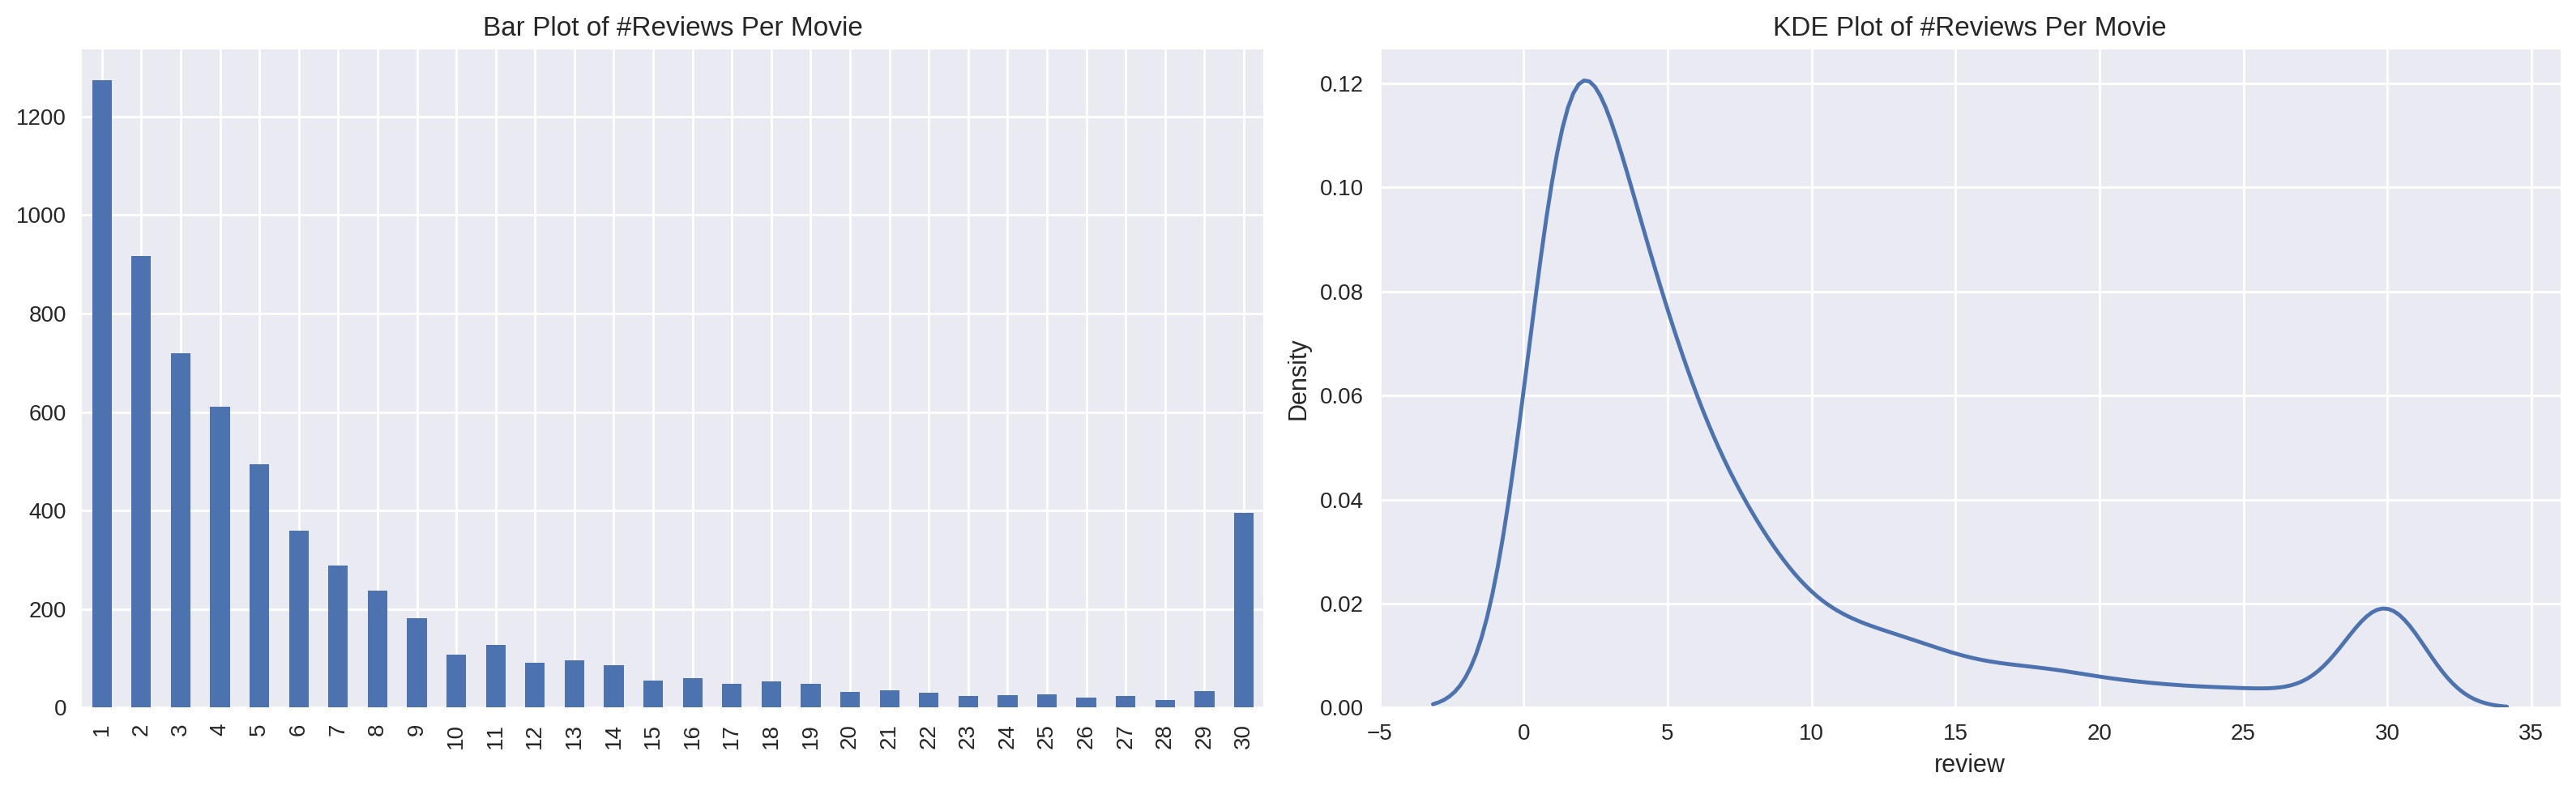

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The most common number of reviews for a movies is just 1. The number of movies per number of reviews decreases significantly until 30 reviews where the number of reviews has a noticeble spike. Seems like it's relatively rare to have many reviews but there is a sizable group of movies that have more reviews than the rest.

In [19]:
df_reviews['pos'].value_counts()

0    23481
1    23271
Name: pos, dtype: int64

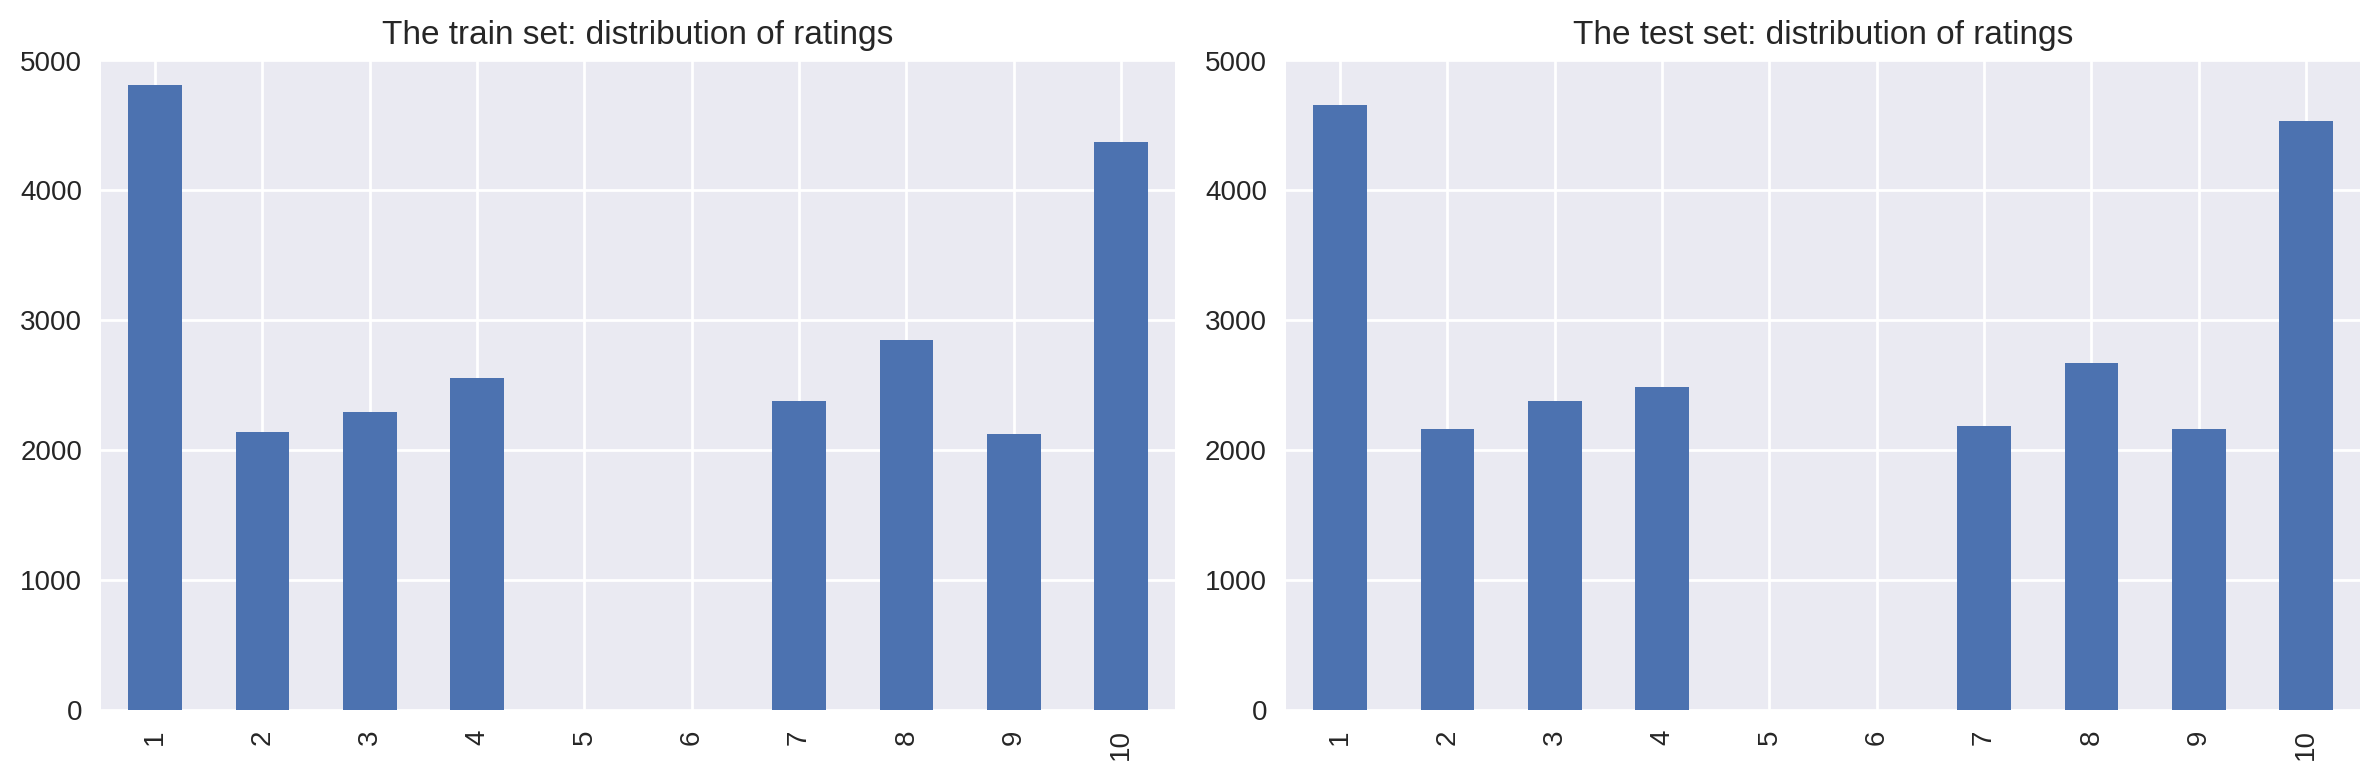

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Seems like the number of positive and negative reviews are nearly equal and the distributions of the training and test sets are also very similar. Interesting that there are virtually no ratings in the middle (5 and 6). Seems like people are very likely to rate movies either a 1 or a 10. This could suggest that the people who review a movie may be prompted by strong feelings in either direction.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


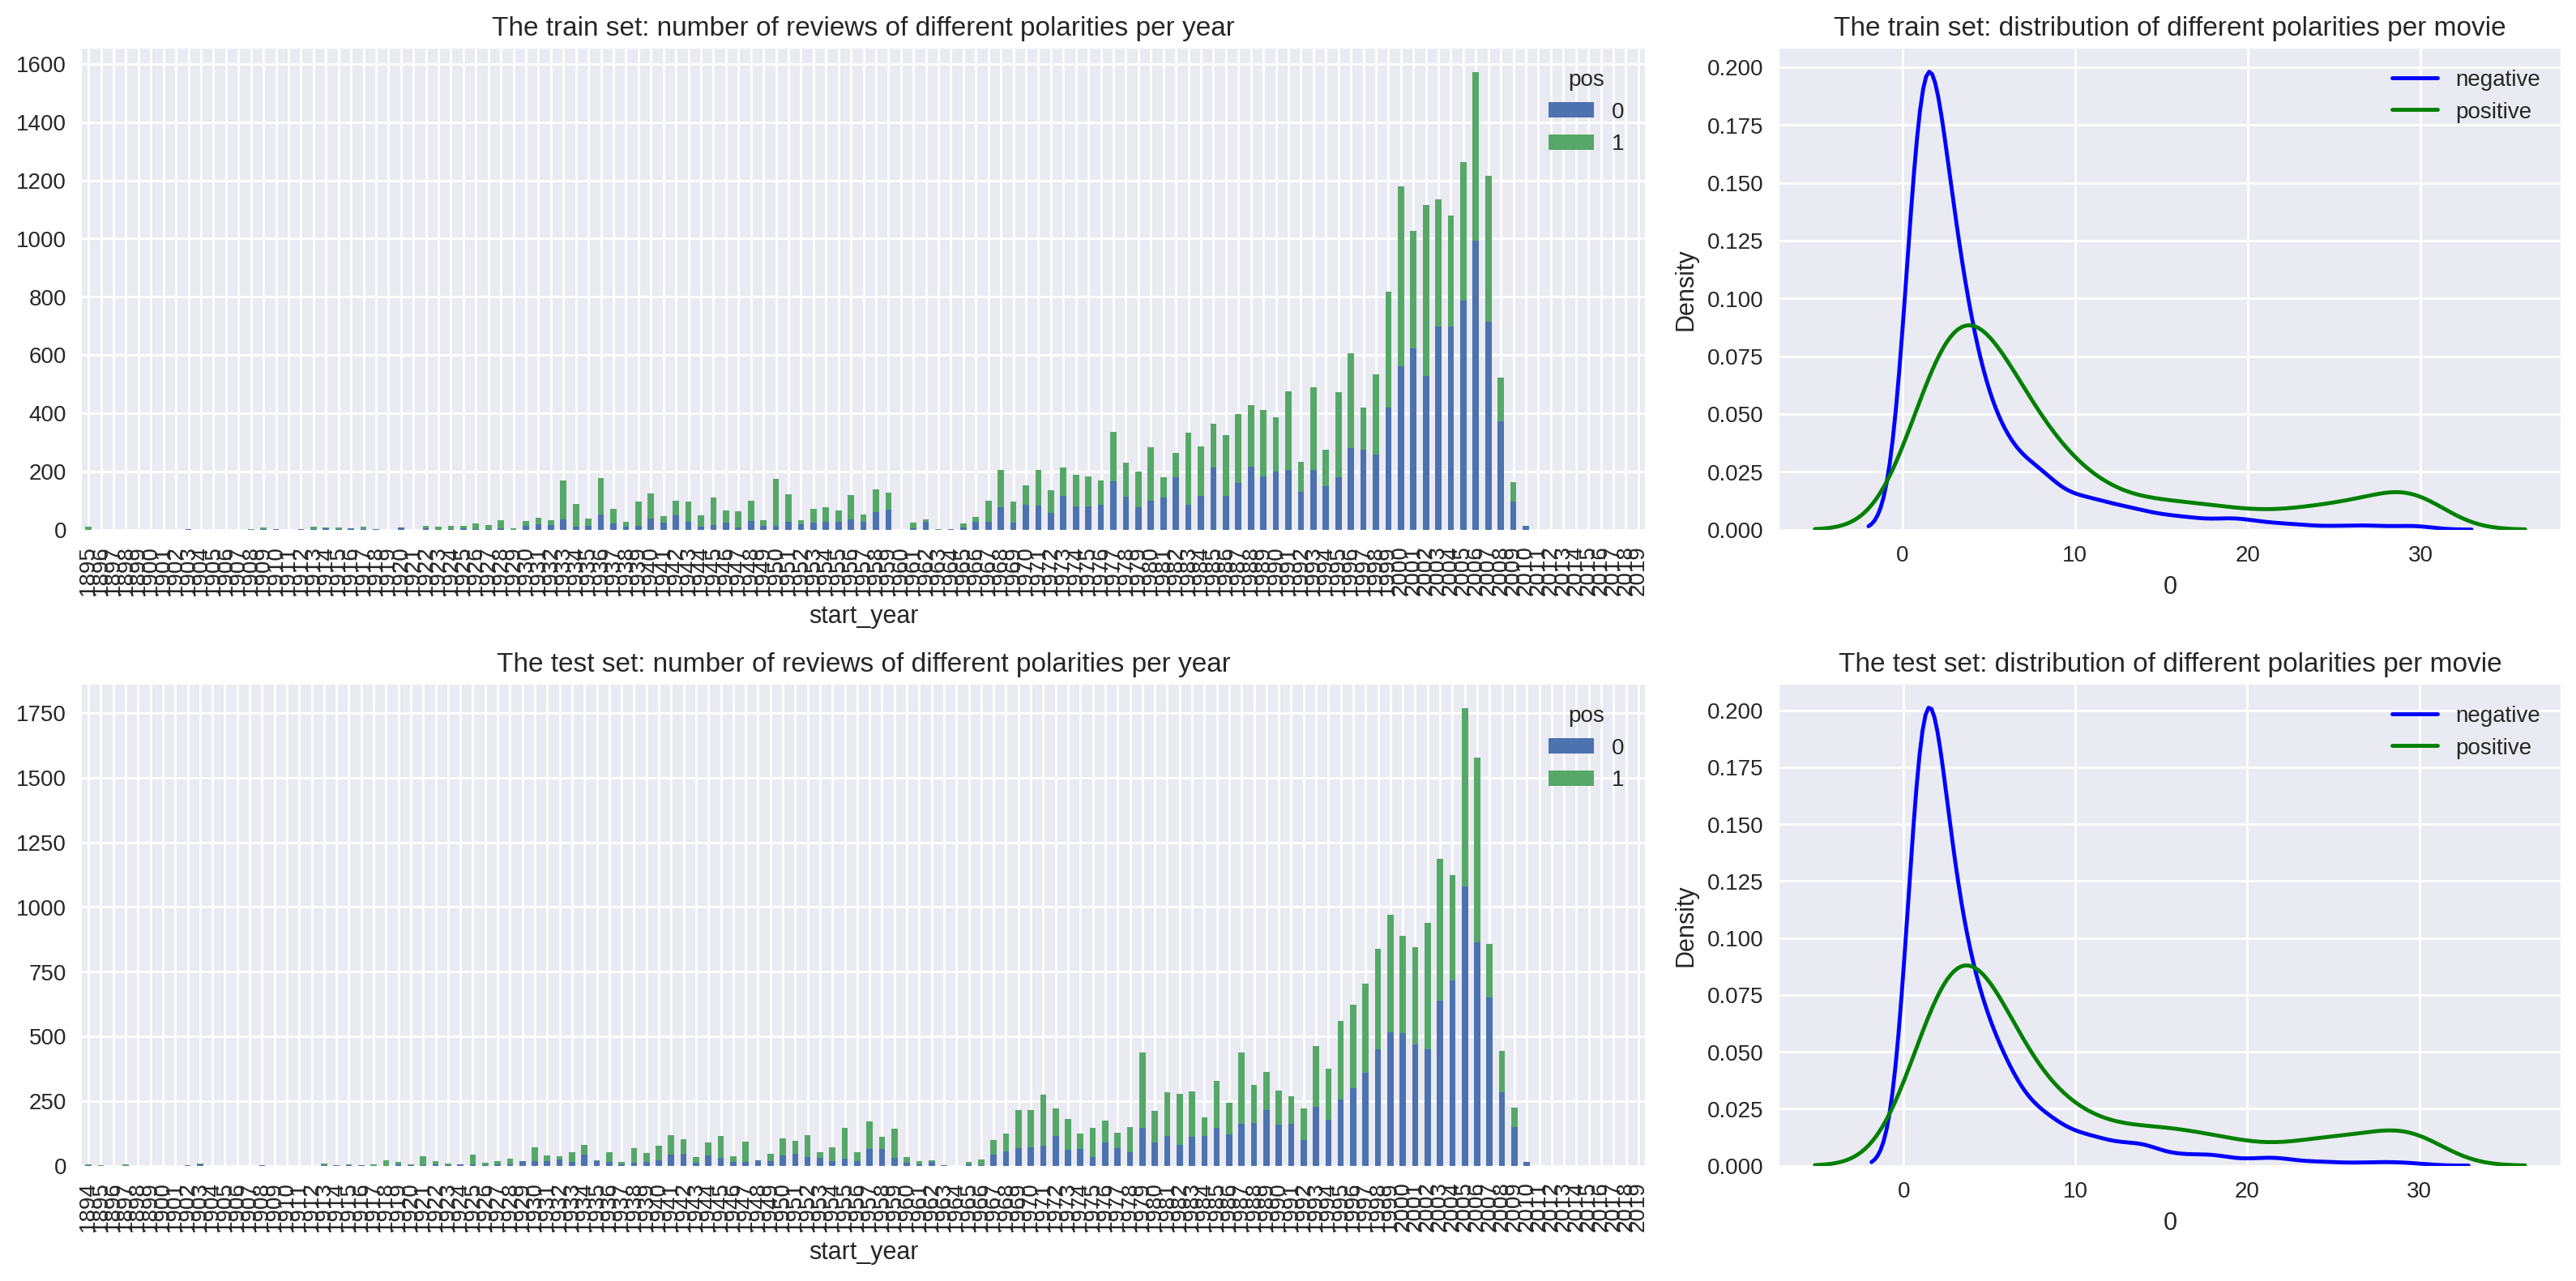

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The KDE plots seem to suggest that if a movie has a lower number of reviews they are more likely to have negative reviews but if they have many reviews they are more likely to be postive. Although there is an upward trend in total reviews over the years there doesn't seem to be any trend in the sentiment of reviewsover the years and the plots of the training and test sets seem pretty similar.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [22]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [23]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^\w\s]', '').str.replace('\d+', '')

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23513, 18)
(23239, 18)


## Working with models

### Model 0 - Constant

In [26]:
# Training Dummy Classifier model to sanity check
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(df_reviews_train['review_norm'], train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


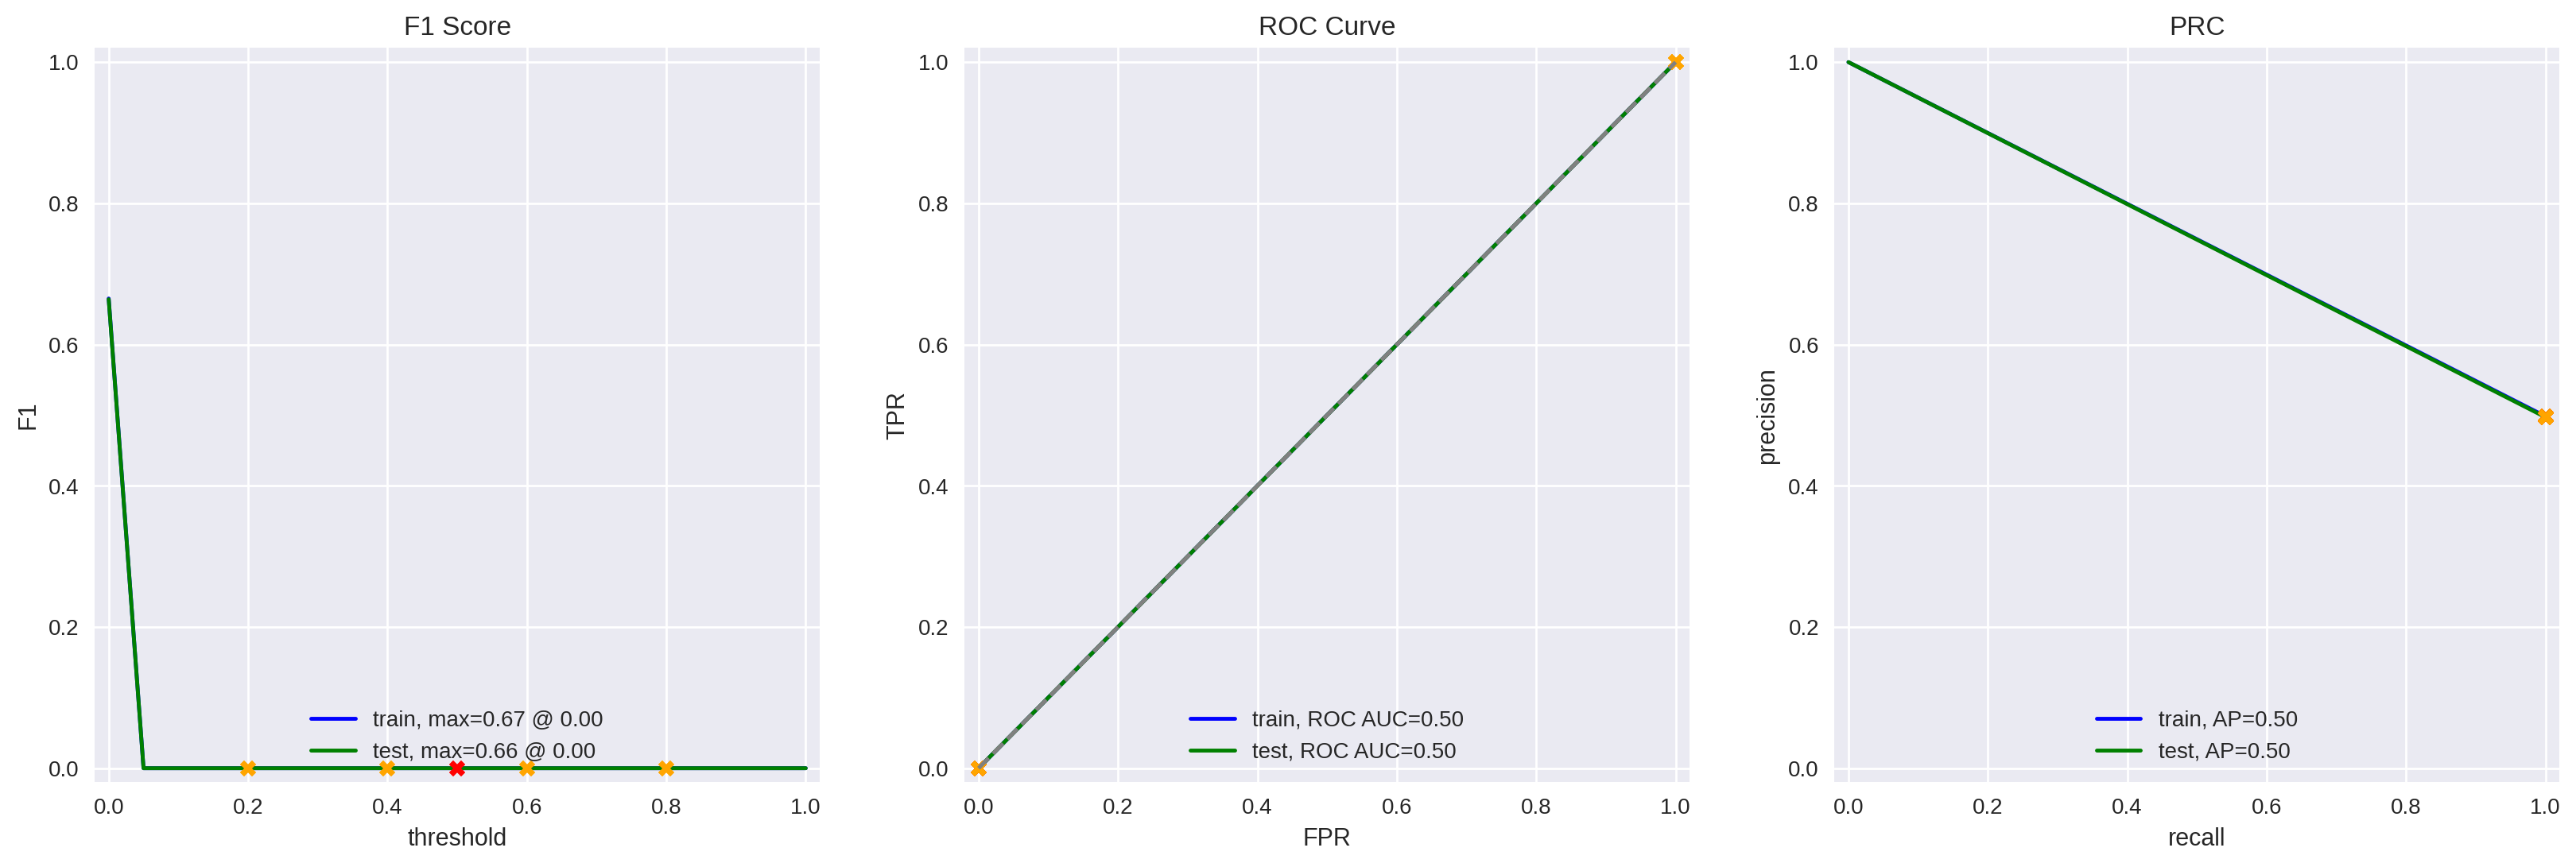

In [27]:
# Evaluating Dummy model
evaluate_model(model_0, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

As expected the performance of the dummy model is poor with a 0 F1 score on both the training and test sets. This is because the model predicted negative every time and there are only slightly more negative reviews than positive. 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [29]:
# Use TF-IDF to transform the text data
nltk.download('stopwords')
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'))
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Training a Logistic Regression model
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


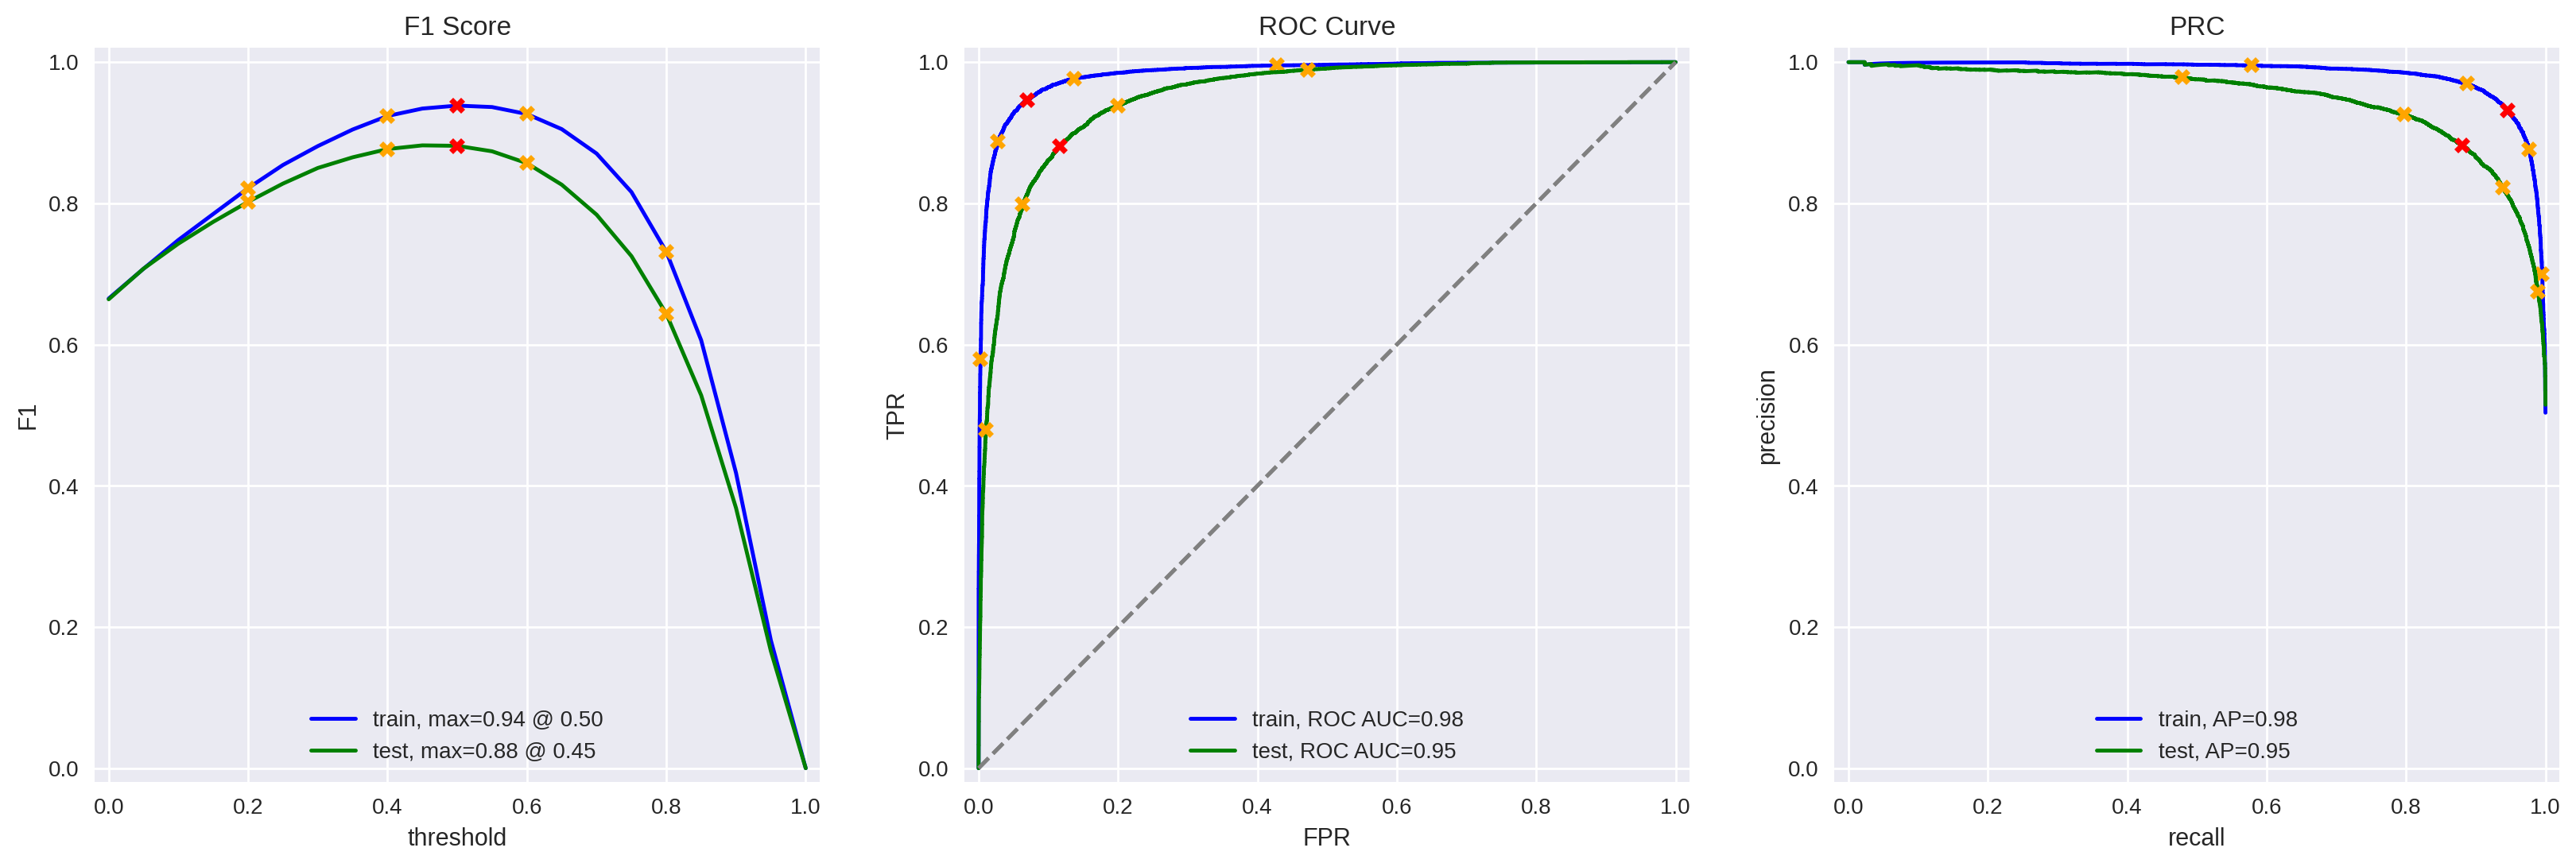

In [31]:
# Evaluating the Logistic Regression model
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The Logistic Regression model using NLTK performed significatnly better than the dummy model. The F1 score on the training set is 0.94 which is above the threshold of 0.85.

### Model 2 - spaCy, TF-IDF and LR

In [32]:
# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
# Define the text preprocessing function using spaCy for lemmatization
def text_preprocessing_2(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
# Apply the text preprocessing to the reviews in the training set
df_reviews_train['review_processed'] = df_reviews_train['review_norm'].apply(text_preprocessing_2)

In [35]:
# Apply the text preprocessing to the reviews in the test set
df_reviews_test['review_processed'] = df_reviews_test['review_norm'].apply(text_preprocessing_2)

In [36]:
# Use TF-IDF to transform the text data
tfidf_vectorizer_2 = TfidfVectorizer(max_features=10000)
train_features_tfidf = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_processed'])
test_features_tfidf = tfidf_vectorizer_2.transform(df_reviews_test['review_processed'])

In [37]:
# Train a Logistic Regression model
model_2 = LogisticRegression(max_iter=1000)
model_2.fit(train_features_tfidf, train_target)

LogisticRegression(max_iter=1000)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


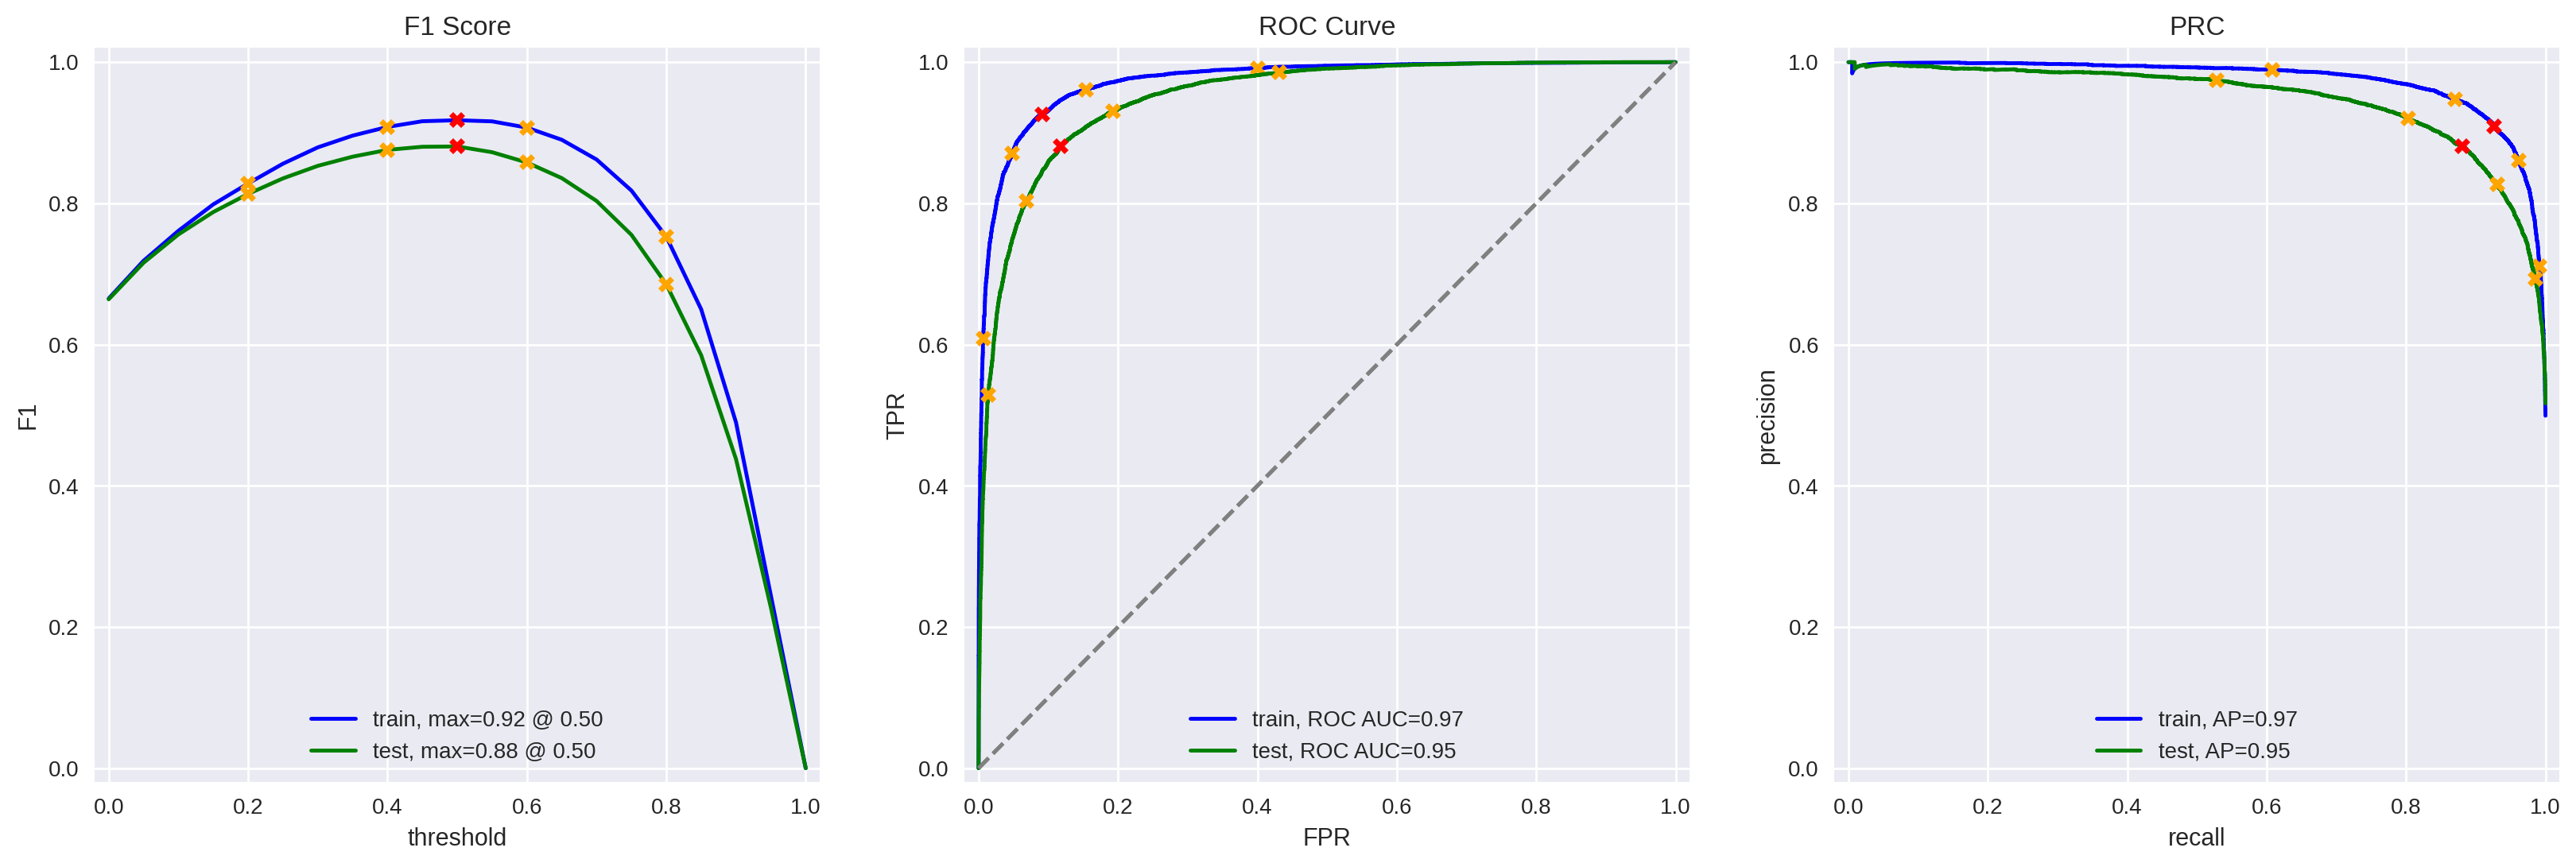

In [38]:
# Evaluate the model using the evaluate_model function
evaluate_model(model_2, train_features_tfidf, train_target, test_features_tfidf, test_target)

The performance of the Logistic Regression model using spaCy is the same as the other on the test set and only slightly worse on the training set.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [40]:
# Train an LGBMClassifier model
model_3 = LGBMClassifier()
model_3.fit(train_features_tfidf, train_target)

LGBMClassifier()

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


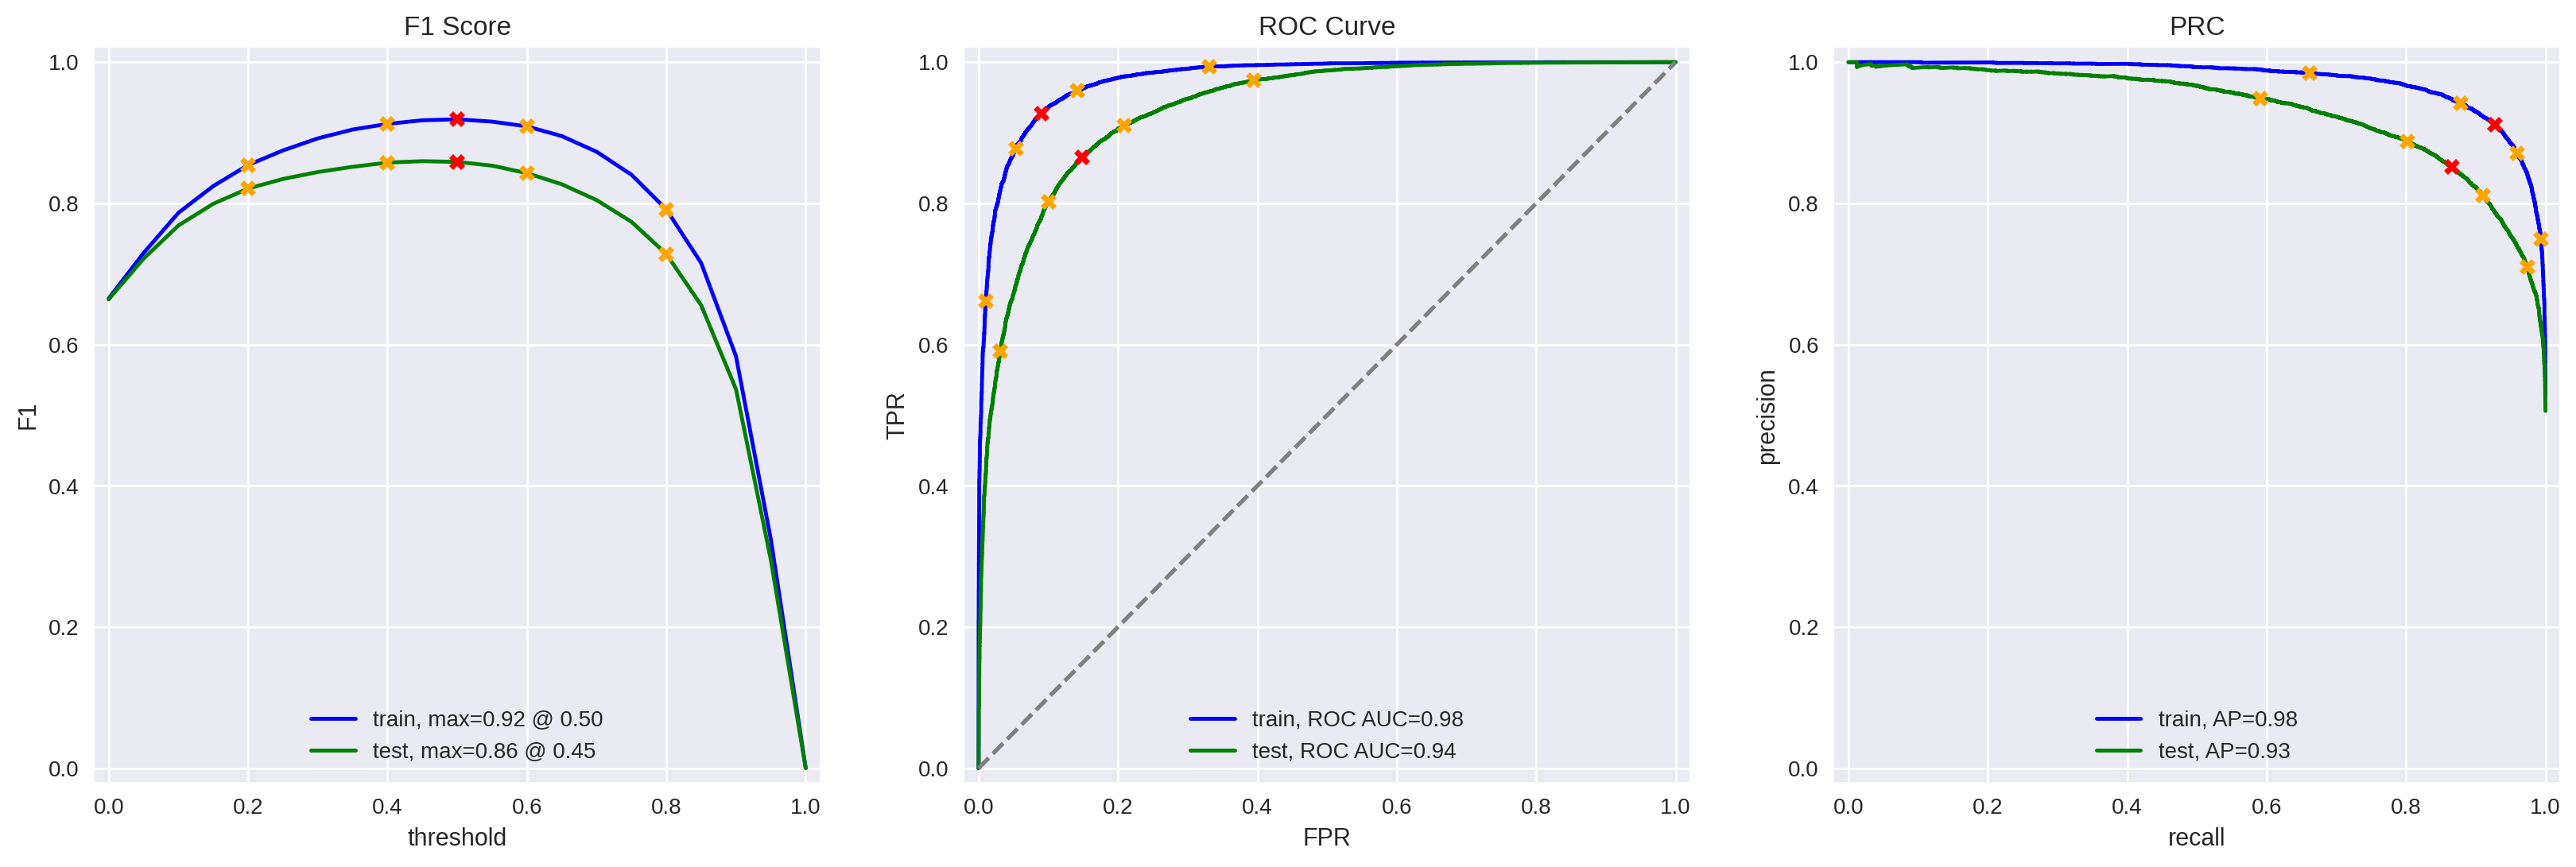

In [41]:
# Evaluate the model using the evaluate_model function
evaluate_model(model_3, train_features_tfidf, train_target, test_features_tfidf, test_target)

The Light GBM Clssifier model did not perform as well as either of the Linear Regression models on the test set but it still met the F1 score threshold with a score of 0.86.

## My Reviews

In [42]:
# Composing reviews to classify with each of the previously trained models.

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^\w\s]', '').str.replace('\d+', '')

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1

In [43]:
# Predicting the probability of the sentiment being postive using model_1
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.25:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


If the threshold was 0.20 every prediction would be correct. However, at the default threshold of 0.5 only 2 positve reviews would be classified correctly and all of the negative reviews would be classified correctly.

### Model 2

In [44]:
# Predicting the probability of the sentiment being postive using model_2
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.20:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.15:  i didnt expect the reboot to be so good writers really cared about the source material
0.71:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


With a threshold of 0.25 there would be one positive review classified incorrectly while all other reviews would be classified correctly and the result would be the same at the default threshold.

### Model 3

In [46]:
# Predicting the probability of the sentiment being postive using model_3
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  i did not simply like it not my kind of movie
0.48:  well i was bored and felt asleep in the middle of the movie
0.65:  i was really fascinated with the movie
0.62:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.49:  i didnt expect the reboot to be so good writers really cared about the source material
0.79:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


Model 3 predicted the negative reviews much higher than the other 2 models. At the default threshold there would be 2 false positives and 1 false negative.

## Conclusions

We trained and evaluated three models:

    NLTK with TF-IDF and Logistic Regression (LR)
    spaCy with TF-IDF and Logistic Regression (LR)
    spaCy with TF-IDF and LightGBM (LGBMClassifier)
    
The performance of the 2 models using Logistic Regression performed very similarly to each other. However, the processing using spaCy took significantly longer. The Light GBM Classifier performed slightly worse than the Logistic Regression models in all metrics on the test set. All of the models surpassed the F1 Threshold.

Overall, it seems like NLTK with TF-IDF and Logistic Regression was the best only due to the faster processing speeds.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions